In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, FrozenEstimator
import optuna
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F


import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Загружаем предобработанные на этапе EDA датасеты для трейна и для теста

In [23]:
# Данные для обучения берутся из аугментированного датасета, в котором бойцы поменяны местами
data_train = pd.read_csv('data_preprocessed/data_final_6596.csv', index_col='Unnamed: 0')
# Данные для тестирования берутся из датасета без аугментации
data_test = pd.read_csv('data_preprocessed/data_test_final_3298.csv', index_col='Unnamed: 0')

Создаем обучающую и тестовую выборки. Поскольку более ранние бои могут нести в себе информацию, влияющую на результат более поздних боев, для теста будем брать самые последние бои во избежание утечки данных

In [24]:
# Определим количество боев, используемое для обучения и оценки моделей
train_edge = int(len(data_train) * 0.25)
test_edge = int(len(data_test) * 0.25) 

# Данные для трейна берем из аугментированного датасета, выделяя из него три четверти
X_train = data_train.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[train_edge:, :]
y_train = data_train['Result'].iloc[train_edge:]

# Данные для теста берем из не аугментированного датасета, выделяя из него одну четверть
X_test = data_test.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[:test_edge, :]
y_test = data_test['Result'].iloc[:test_edge]

In [85]:
data_test.drop(columns=['Result', 'RedFighter', 'BlueFighter'], axis=1).iloc[:test_edge, :]

,RedStance,BlueStance,RedOdds,BlueOdds,Age_diff,Height_diff,Reach_diff,Weight_diff,WinsByKO/TKO_diff,WinsBySubmission_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,0.0,0.0,-210.0,295.0,3,-5.08,7.62,0,-2,5,...,-1.38,0.06,0.72,-0.26,1.5,-2,-9,196,4.0,-2
2,0.0,0.0,-380.0,300.0,-2,-7.62,2.54,-5,-2,1,...,0.36,0.03,0.13,-0.42,0.3,3,-11,294,1.0,-3
3,1.0,1.0,-950.0,625.0,-6,2.54,0.00,0,0,0,...,-1.44,0.14,2.98,0.16,1.1,5,15,-224,3.0,1
4,0.0,0.0,-130.0,110.0,3,-2.54,5.08,0,-3,2,...,1.84,-0.07,0.25,0.04,0.2,0,2,112,0.0,0
5,1.0,0.0,-380.0,300.0,-2,0.00,2.54,0,-3,-5,...,1.63,0.01,-0.11,0.02,-0.3,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1.0,0.0,-180.0,155.0,3,-2.54,10.16,0,1,1,...,0.41,0.13,-0.11,-0.15,0.1,2,7,63,0.0,3
1118,0.0,0.0,-195.0,165.0,-5,-10.16,-17.78,-10,2,-5,...,-1.24,-0.03,0.29,-0.11,-1.6,1,2,308,0.0,0
1119,1.0,1.0,-140.0,120.0,-3,-5.08,-2.54,0,2,0,...,0.12,-0.04,-0.07,0.22,0.3,3,4,301,0.0,2
1120,1.0,0.0,-125.0,105.0,7,-2.54,5.08,0,0,-4,...,-1.00,-0.11,-0.41,-0.08,-1.3,1,24,42,0.0,0


Масштабируем числовые признаки. Категориальных признаков у нас нет.

In [27]:
# Масштабируйте данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
data_test

,RedFighter,BlueFighter,RedStance,BlueStance,RedOdds,BlueOdds,Result,Age_diff,Height_diff,Reach_diff,...,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,LongestWinStreak_diff,TotalRoundsFought_diff,TimeSinceLastFight_diff,Rank_diff,Curr_streak_diff
1,Shavkat Rakhmonov,Ian Machado Garry,0.0,0.0,-210.0,295.0,0,3,-5.08,7.62,...,-1.38,0.060,0.7200,-0.260,1.5000,-2,-9,196,4.0,-2
2,Ciryl Gane,Alexander Volkov,0.0,0.0,-380.0,300.0,0,-2,-7.62,2.54,...,0.36,0.030,0.1300,-0.420,0.3000,3,-11,294,1.0,-3
3,Bryce Mitchell,Kron Gracie,1.0,1.0,-950.0,625.0,0,-6,2.54,0.00,...,-1.44,0.140,2.9800,0.160,1.1000,5,15,-224,3.0,1
4,Nate Landwehr,Dooho Choi,0.0,0.0,-130.0,110.0,1,3,-2.54,5.08,...,1.84,-0.070,0.2500,0.040,0.2000,0,2,112,0.0,0
5,Dominick Reyes,Anthony Smith,1.0,0.0,-380.0,300.0,0,-2,0.00,2.54,...,1.63,0.010,-0.1100,0.020,-0.3000,3,-42,21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,Frank Mir,Shane Carwin,1.0,0.0,-150.0,140.0,1,-5,2.54,-2.54,...,3.00,0.083,0.4667,0.184,1.2667,1,17,0,0.0,-2
6512,Nate Diaz,Rory Markham,1.0,0.0,-235.0,195.0,0,-4,0.00,12.70,...,0.57,0.134,1.3333,0.476,1.4444,4,18,0,0.0,0
6518,Junior Dos Santos,Gabriel Gonzaga,0.0,0.0,-250.0,230.0,0,-4,5.08,2.54,...,-9.04,-0.010,-1.2000,-0.572,-0.7000,0,-10,0,0.0,3
6521,Clay Guida,Shannon Gugerty,0.0,0.0,-420.0,335.0,0,0,-7.62,-2.54,...,-8.18,0.061,2.1500,-0.281,-0.6500,2,19,0,0.0,-1


### Подготовка к обучению моделей

Создадим словарь, в который будем добавлять построенные модели

In [41]:
models = {}

Напишем функции для вывода результатов

In [31]:
def display_results(y_test, y_pred):
    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('predicted value')

In [76]:
def plot_confidence(y_test, y_proba, model=None):
    # Калибровочная кривая
    y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
    prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")
    
    # Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
    plt.xlabel('Предсказанная вероятность')
    plt.ylabel('Эмпирическая вероятность')
    plt.title(f'График калибровки классификатора')
    plt.legend()

In [313]:
def prob_calibration(X_test, y_test, model, use_frozen=False):
   
    if not use_frozen:
        calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
    else:
        calibrated_model = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic', cv='prefit')
        
    calibrated_model.fit(X_test, y_test)
    # Предсказанные вероятности после калибровки
    calibrated_proba = calibrated_model.predict_proba(X_test)
    # # Калибровочная кривая
    # prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

    y_pred_calibrated = calibrated_model.predict(X_test)
    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred_calibrated))

    # График вероятностей
    plt.hist(calibrated_proba[:, 0], alpha=0.5, label='Класс 0')
    plt.hist(calibrated_proba[:, 1], alpha=0.5, label='Класс 1')
    plt.xlabel('Вероятность')
    plt.ylabel('Частота')
    plt.title('График вероятностей')
    plt.legend()
    plt.show()

Введем свою бизнес-метрику, равную сумме выигрыша, который можно получить, поставив на исход каждого боя в соответствии с предсказанием модели относительно того, кто из двух бойцов победит. 

Сумму выигрыша будем рассчитывать исходя из реальных коэффициентов на каждого бойца, определяемых букмекерами. В датасете есть соответствующие признаки `RedOdds` и `BlueOdds`

In [64]:
def calc_odds(row):
    for col in ['RedOdds', 'BlueOdds']:
        if row[col] > 0:
            row[col] = row[col] / 100 + 1
        else:
            row[col] = 100 / np.abs(row[col]) + 1
    return row

import random

def calc_model_gain(row, stake_size = 1000):
    if row['PredError'] == 0:
        return int((row['RedOdds'], row['BlueOdds'])[row['ActualWinner']] * stake_size)
    else:
        return - stake_size
    
def calc_odds_gain(row, stake_size = 1000):
    if row['ActualWinner'] == 0 and row['RedOdds'] < row['BlueOdds']:
        return int(row['RedOdds'] * stake_size)
    elif row['ActualWinner'] == 1 and row['RedOdds'] > row['BlueOdds']:
        return int(row['BlueOdds'] * stake_size)
    else:
        return - stake_size


def calc_guess_gain(row, stake_size = 1000):
    odds = (row['RedOdds'], row['BlueOdds'])
    odds_number = (0, 1)
    chosen_odd = random.choice(odds_number)  # Выбираем случайный элемент из кортежа
    if chosen_odd == row['ActualWinner']:
        return int(odds[chosen_odd] * stake_size)
    else:
        return - stake_size

Для наглядного представления результатов создадим датафрейм, куда будут собраны:
- результаты всех боев;
- результаты предсказаний модели;
- ошибки предсказаний модели;
- коэффициенты букмекеро на каждого бойца 

In [66]:
def display_business_metrics(y_proba):
    # Создание датафрейма для хранения результатов
    results_df = pd.DataFrame({
                                'RedFighter': data_test['RedFighter'].iloc[:test_edge],
                                'BlueFighter': data_test['BlueFighter'].iloc[:test_edge],
                                'RedOdds': data_test['RedOdds'].iloc[:test_edge],
                                'BlueOdds': data_test['BlueOdds'].iloc[:test_edge],
                                'ProbRedWins': y_proba [:, 0],
                                'ProbBlueWins': y_proba [:, 1],
                                'ActualWinner': data_test['Result'].iloc[:test_edge]
                              })
    # Создаем дополнительные столбцы
    results_df['PredWinner'] = (results_df['ProbBlueWins'] > results_df['ProbRedWins']).astype(int)
    results_df['PredError'] = np.abs(results_df['PredWinner'] - results_df['ActualWinner'])
    results_df.iloc[:, :]

    # Рассчитывем сумму выигрыша
    results_df = results_df.apply(calc_odds, axis=1)
    results_df['GainModel'] = results_df.apply(calc_model_gain, axis=1) # Ставки на основании прогнозов модели
    results_df['GainOdds'] = results_df.apply(calc_odds_gain, axis=1) # Ставки на основании коэффициентов букмекеров (ставим на фаворита)
    results_df['GainGuess'] = results_df.apply(calc_guess_gain, axis=1) # Ставки, сделанные случайным образом

    print(f'Результат выигрыша при использовании модели: {results_df['GainModel'].sum()} рублей')
    print(f'Результат выигрыша при использовании ставок: {results_df['GainOdds'].sum()} рублей')
    print(f'Результат выигрыша при случайном угадывании: {results_df['GainGuess'].sum()} рублей')
    return results_df

### 1. Логистическая регрессия

In [251]:
params = {'penalty': [None, 'l1', 'l2'],
          'C': np.linspace(0.001, 10000, 24),
          'solver': ['liblinear', 'newton-cs'],
          'class_weight': [None],
          'fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_logreg = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем модель на тренировочных данных
gs_logreg.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_logreg.predict(X_test)
y_proba = gs_logreg.predict_proba(X_test)

# Добавляем обученную модель и ее предсказания в словарь
models['logreg'] = [gs_logreg.best_estimator_, y_pred, y_proba]

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       465
           1       0.66      0.61      0.64       359

    accuracy                           0.69       824
   macro avg       0.69      0.68      0.69       824
weighted avg       0.69      0.69      0.69       824



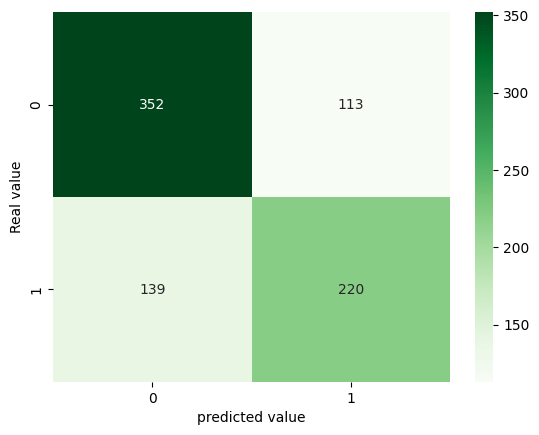

In [252]:
display_results(y_test, models['logreg'][1])

Построим график уверенности классификатора относительно сделанных прогнозов

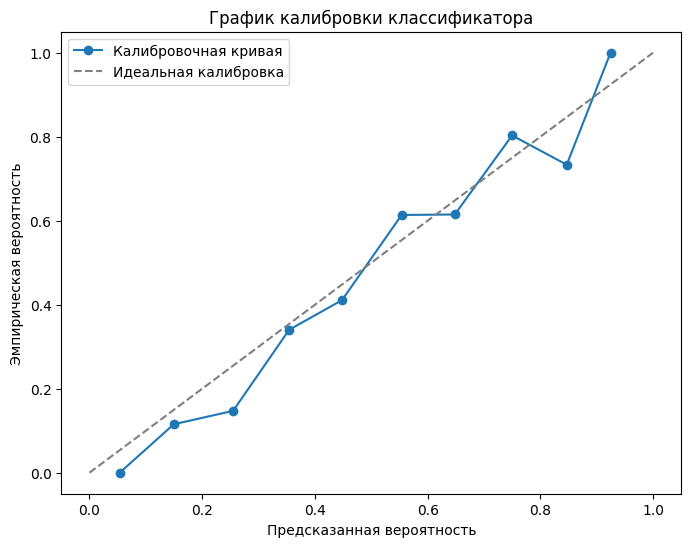

In [253]:
plot_confidence(y_test, models['logreg'][2], models['logreg'][0])

Откалибруем уверенность классификатора при помощи изотонической регрессии 

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       465
           1       0.68      0.60      0.64       359

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.69       824
weighted avg       0.70      0.70      0.70       824



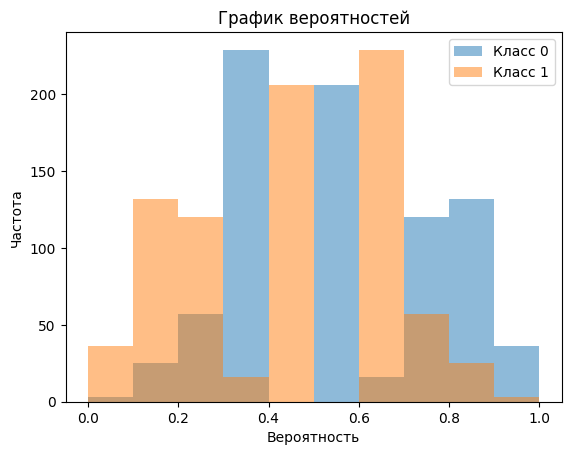

In [254]:
prob_calibration(X_test, y_test, models['logreg'][2], models['logreg'][0])

In [255]:
display_business_metrics(models['logreg'][2])

Результат выигрыша при использовании модели: 589757 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 387067 рублей


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.718774,0.281226,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.744001,0.255999,0,0,0,1263,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.937154,0.062846,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.576164,0.423836,1,0,1,-1000,-1000,-1000
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.669059,0.330941,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.634715,0.365285,1,0,1,-1000,-1000,-1000
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.609139,0.390861,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.568867,0.431133,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.567037,0.432963,1,0,1,-1000,-1000,2050


### 2. XGBoost

In [257]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

models['XGBoost'] = [best_model, y_pred, y_proba]

[I 2025-01-22 14:20:58,548] A new study created in memory with name: no-name-04199696-4cde-4bd0-9514-928c4bde397c
[I 2025-01-22 14:20:58,835] Trial 0 finished with value: 0.6376404494382022 and parameters: {'max_depth': 7, 'learning_rate': 0.017807852919038508, 'n_estimators': 84, 'gamma': 0.05509127981314367, 'subsample': 0.7517115218025232, 'colsample_bytree': 0.8895069346224733, 'reg_alpha': 1.9195939978840932, 'reg_lambda': 4.508788426380122}. Best is trial 0 with value: 0.6376404494382022.
[I 2025-01-22 14:20:58,919] Trial 1 finished with value: 0.6024759284731774 and parameters: {'max_depth': 6, 'learning_rate': 0.3238264249370034, 'n_estimators': 66, 'gamma': 0.023181468343819563, 'subsample': 0.9281724598487625, 'colsample_bytree': 0.213858520148065, 'reg_alpha': 0.10963075036585279, 'reg_lambda': 0.31919283137241605}. Best is trial 0 with value: 0.6376404494382022.
[I 2025-01-22 14:20:58,979] Trial 2 finished with value: 0.6427586206896552 and parameters: {'max_depth': 16, 'le

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       465
           1       0.67      0.66      0.67       359

    accuracy                           0.71       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.71      0.71      0.71       824



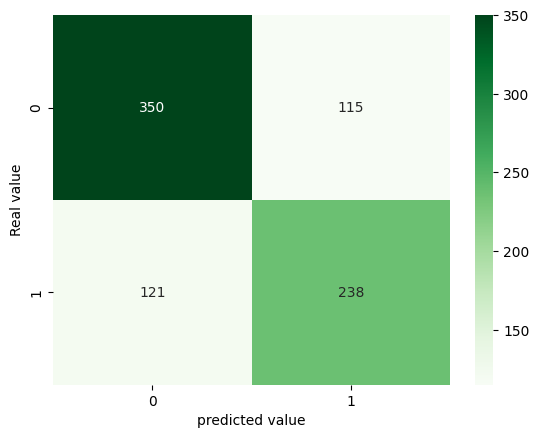

In [258]:
display_results(y_test, models['XGBoost'][1])

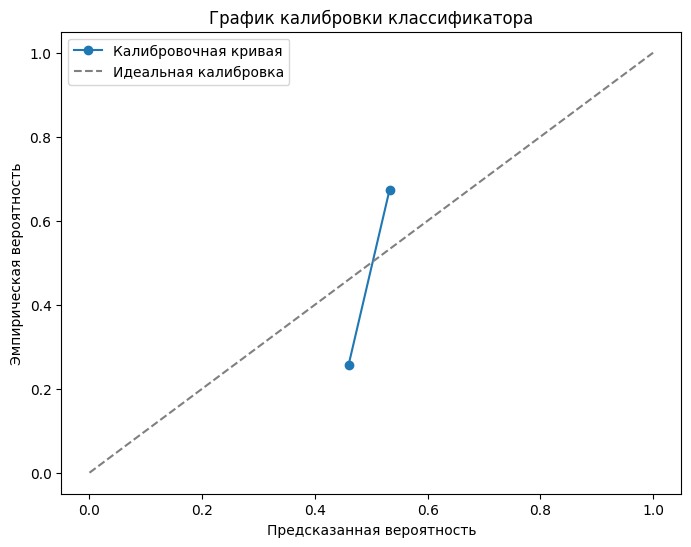

In [259]:
plot_confidence(y_test, models['XGBoost'][2], models['XGBoost'][0])

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       465
           1       0.69      0.64      0.66       359

    accuracy                           0.72       824
   macro avg       0.71      0.71      0.71       824
weighted avg       0.71      0.72      0.71       824



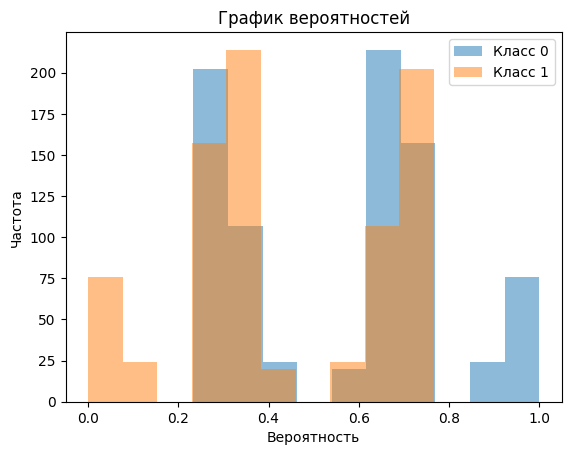

In [260]:
prob_calibration(X_test, y_test, models['XGBoost'][2], models['XGBoost'][0], is_frozen=True)

In [261]:
display_business_metrics(y_proba)

Результат выигрыша при использовании модели: 632073 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 338601 рублей


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.546222,0.453778,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.580951,0.419049,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.585910,0.414090,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.502942,0.497058,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.577602,0.422398,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.520565,0.479435,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.525358,0.474642,0,0,0,1512,1512,1512
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.514533,0.485467,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.497941,0.502059,1,1,0,2050,-1000,2050


### 3. Нейронная сеть 

In [314]:
# Определение датасета
class FighterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Создание датасета и даталоадера
train_dataset = FighterDataset(X_train, y_train)
test_dataset = FighterDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [292]:
class FighterNet(nn.Module):
    def __init__(self):
        super(FighterNet, self).__init__()
        self.fc1 = nn.Linear(22, 128)  # входной слой
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 128)  # скрытый слой
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(128, 64)  # скрытый слой
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(64, 64)  # скрытый слой
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)  # скрытый слой
        self.dropout5 = nn.Dropout(p=0.2)
        self.fc6 = nn.Linear(32, 2)  # выходной слой   

    def forward(self, x):        
        x = torch.relu(self.fc1(x))  # активация ReLU
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))  # активация ReLU
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # активация ReLU
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # активация ReLU
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))  # активация ReLU
        x = self.dropout5(x)
        x = self.fc6(x)
        return x

In [294]:
# Инициализация нейронной сети и оптимизатора
net = FighterNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Обучение нейронной сети
for epoch in range(40):
    for batch in train_dataloader:
        x, y = batch  # распаковка списка в две переменные
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y.long())  # преобразование меток в long
        loss.backward()
        optimizer.step()
    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

Эпоха 1, потеря: 0.6818617582321167
Эпоха 2, потеря: 0.6945963501930237
Эпоха 3, потеря: 0.6525205373764038
Эпоха 4, потеря: 0.6136518716812134
Эпоха 5, потеря: 0.6794541478157043
Эпоха 6, потеря: 0.6417461037635803
Эпоха 7, потеря: 0.7898195385932922
Эпоха 8, потеря: 0.6509767174720764
Эпоха 9, потеря: 0.652454674243927
Эпоха 10, потеря: 0.6122539639472961
Эпоха 11, потеря: 0.5770798921585083
Эпоха 12, потеря: 0.7627646327018738
Эпоха 13, потеря: 0.6410602927207947
Эпоха 14, потеря: 0.7198411822319031
Эпоха 15, потеря: 0.6119435429573059
Эпоха 16, потеря: 0.5927306413650513
Эпоха 17, потеря: 0.5583180785179138
Эпоха 18, потеря: 0.5493654012680054
Эпоха 19, потеря: 0.6261392831802368
Эпоха 20, потеря: 0.5522613525390625
Эпоха 21, потеря: 0.570688784122467
Эпоха 22, потеря: 0.6607628464698792
Эпоха 23, потеря: 0.5208333730697632
Эпоха 24, потеря: 0.5173985958099365
Эпоха 25, потеря: 0.6786567568778992
Эпоха 26, потеря: 0.656446099281311
Эпоха 27, потеря: 0.8993539214134216
Эпоха 28, пот

In [295]:
# Оценка модели на тестовых данных
net.eval()
y_proba = []
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        x, y = batch 
        outputs = net(x)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_pred_proba = torch.nn.functional.softmax(outputs, dim=1)
        y_proba.extend(y_pred_proba.numpy())
        y_true.extend(y.cpu().numpy())

print(f'f1_score: {f1_score(y_true, y_pred, average='weighted'):.3f}')
y_proba = np.array(y_proba)

models['NN'] = [net, y_pred, y_proba]

f1_score: 0.681


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       465
           1       0.63      0.65      0.64       359

    accuracy                           0.68       824
   macro avg       0.68      0.68      0.68       824
weighted avg       0.68      0.68      0.68       824



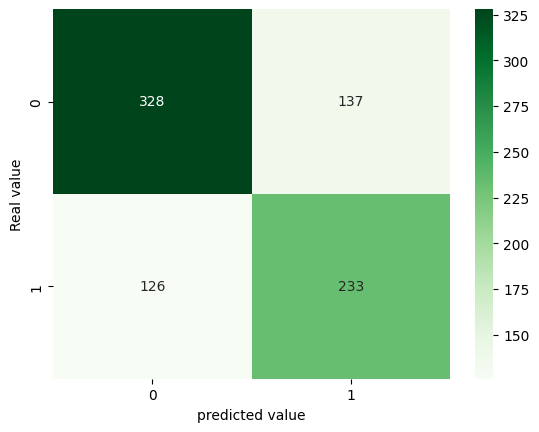

In [296]:
display_results(y_test, models['NN'][1])

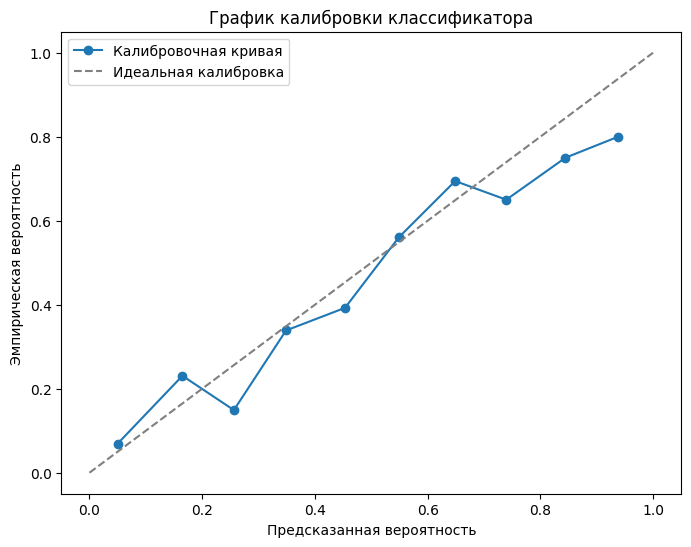

In [297]:
plot_confidence(y_test, models['NN'][2])

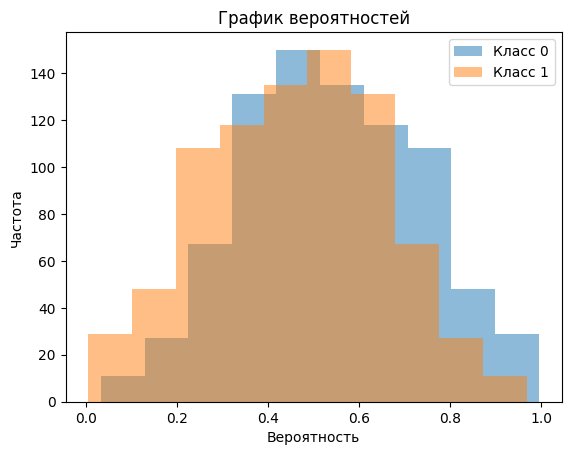

In [324]:
y_proba = models['NN'][2]
plt.hist(y_proba[:, 0], alpha=0.5, label='Класс 0')
plt.hist(y_proba[:, 1], alpha=0.5, label='Класс 1')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('График вероятностей')
plt.legend()
plt.show()

In [299]:
display_business_metrics(models['NN'][2])

Результат выигрыша при использовании модели: 564551 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 355425 рублей


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.707296,0.292704,0,0,0,1476,1476,-1000
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.736047,0.263953,0,0,0,1263,1263,-1000
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.963442,0.036558,0,0,0,1105,1105,-1000
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.498871,0.501129,1,1,0,2100,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.658479,0.341521,0,0,0,1263,1263,1263
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.686190,0.313810,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.607893,0.392107,0,0,0,1512,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.712037,0.287963,0,0,0,1714,1714,1714
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.496453,0.503547,1,1,0,2050,-1000,2050


### 4. RNN

In [300]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        c0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return torch.sigmoid(out)

In [301]:
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)

# Обучение модели
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.002)

for epoch in range(30):
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.float()  
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6939668655395508
Epoch 2, Loss: 0.5633015036582947
Epoch 3, Loss: 0.5530017018318176
Epoch 4, Loss: 0.6324048638343811
Epoch 5, Loss: 0.6732572913169861
Epoch 6, Loss: 0.6010422706604004
Epoch 7, Loss: 0.7528030872344971
Epoch 8, Loss: 0.48117998242378235
Epoch 9, Loss: 0.7046976685523987
Epoch 10, Loss: 0.7063146829605103
Epoch 11, Loss: 0.9208627939224243
Epoch 12, Loss: 0.7184513211250305
Epoch 13, Loss: 0.6537479162216187
Epoch 14, Loss: 0.6598771810531616
Epoch 15, Loss: 0.6868284344673157
Epoch 16, Loss: 0.6654594540596008
Epoch 17, Loss: 0.7410029172897339
Epoch 18, Loss: 0.5700860023498535
Epoch 19, Loss: 0.7289999723434448
Epoch 20, Loss: 0.5890797972679138
Epoch 21, Loss: 0.5686224102973938
Epoch 22, Loss: 0.6072494983673096
Epoch 23, Loss: 0.7433130145072937
Epoch 24, Loss: 0.648779034614563
Epoch 25, Loss: 0.6528869271278381
Epoch 26, Loss: 0.5751979947090149
Epoch 27, Loss: 0.5797837972640991
Epoch 28, Loss: 0.7033988833427429
Epoch 29, Loss: 0.66368854045

In [305]:
# Оценка модели
model.eval()
with torch.no_grad():
    total_correct = 0
    predicted_labels = []
    test_labels = []
    predicted_probas = []
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        predicted_labels.extend(predicted.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())
        predicted_probas.extend(outputs.numpy().flatten())        

# Преобразовать списки в numpy массивы
y_pred = np.array(predicted_labels)
y_proba_1 = np.array(predicted_probas)
y_proba_0 = 1 - np.array(predicted_probas)
y_proba = np.stack((y_proba_0, y_proba_1), axis=1)

models['RNN'] = [model, y_pred, y_proba]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       465
           1       0.67      0.62      0.64       359

    accuracy                           0.70       824
   macro avg       0.70      0.69      0.69       824
weighted avg       0.70      0.70      0.70       824



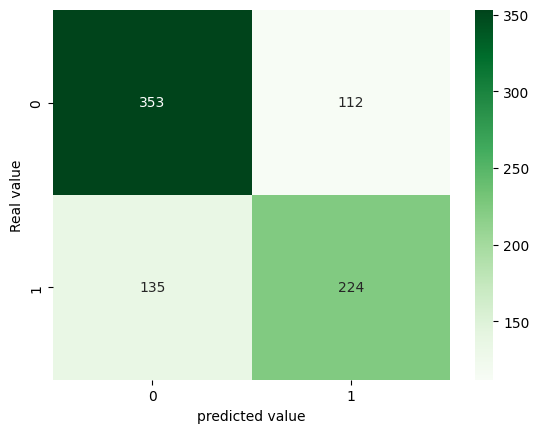

In [307]:
display_results(y_test, models['RNN'][1])

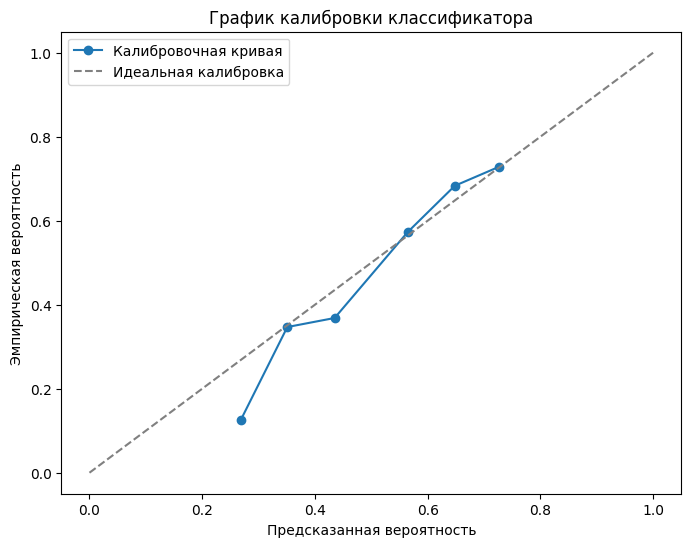

In [308]:
plot_confidence(y_test, models['RNN'][2])

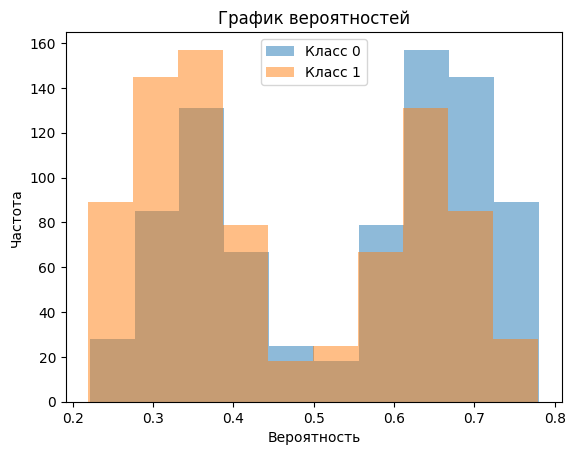

In [310]:
y_proba = models['RNN'][2]
plt.hist(y_proba[:, 0], alpha=0.5, label='Класс 0')
plt.hist(y_proba[:, 1], alpha=0.5, label='Класс 1')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('График вероятностей')
plt.legend()
plt.show()

In [311]:
display_business_metrics(models['RNN'][2])

Результат выигрыша при использовании модели: 596869 рублей
Результат выигрыша при использовании ставок: 589370 рублей
Результат выигрыша при случайном угадывании: 380254 рублей


,RedFighter,BlueFighter,RedOdds,BlueOdds,ProbRedWins,ProbBlueWins,ActualWinner,PredWinner,PredError,GainModel,GainOdds,GainGuess
1,Shavkat Rakhmonov,Ian Machado Garry,1.476190,3.950000,0.677233,0.322767,0,0,0,1476,1476,1476
2,Ciryl Gane,Alexander Volkov,1.263158,4.000000,0.700035,0.299965,0,0,0,1263,1263,1263
3,Bryce Mitchell,Kron Gracie,1.105263,7.250000,0.770933,0.229067,0,0,0,1105,1105,1105
4,Nate Landwehr,Dooho Choi,1.769231,2.100000,0.602747,0.397253,1,0,1,-1000,-1000,2100
5,Dominick Reyes,Anthony Smith,1.263158,4.000000,0.708900,0.291100,0,0,0,1263,1263,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,John Castaneda,Daniel Santos,1.555556,2.550000,0.641614,0.358386,1,0,1,-1000,-1000,2550
1118,Ilir Latifi,Aleksei Oleinik,1.512821,2.650000,0.609162,0.390838,0,0,0,1512,1512,-1000
1119,Joaquim Silva,Jesse Ronson,1.714286,2.200000,0.604747,0.395253,0,0,0,1714,1714,-1000
1120,Krzysztof Jotko,Brendan Allen,1.800000,2.050000,0.568926,0.431074,1,0,1,-1000,-1000,2050


### Модели, обученные на данных без Feature Engineering

### Гибридная RNN

### 5. Сиамская сеть

In [326]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(22, 128)  
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x1 = torch.relu(self.fc1(x1))
        x1 = torch.relu(self.fc2(x1))
        x1 = self.fc3(x1)

        x2 = torch.relu(self.fc1(x2))
        x2 = torch.relu(self.fc2(x2))
        x2 = self.fc3(x2)

        outputs = torch.sigmoid(x1 - x2)
        return outputs

In [346]:
# Обучение сиамской нейросети
model = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for batch in train_dataloader:
        x, y = batch        
        optimizer.zero_grad()
        mid = len(x) // 2
        x1 = x[:mid]
        x2 = x[mid:mid + mid]
        outputs = model(x1, x2)
        loss = criterion(outputs, y[:mid].view(-1, 1).float())
        loss.backward()
        optimizer.step()
        print(f'Эпоха {epoch+1}, потеря: {loss.item()}') 

Эпоха 1, потеря: 0.6931695938110352
Эпоха 1, потеря: 0.5996143221855164
Эпоха 1, потеря: 0.7531030774116516
Эпоха 1, потеря: 0.5966495275497437
Эпоха 1, потеря: 0.7220668792724609
Эпоха 1, потеря: 0.6912258267402649
Эпоха 1, потеря: 0.7249302864074707
Эпоха 1, потеря: 0.7507284879684448
Эпоха 1, потеря: 0.7163393497467041
Эпоха 1, потеря: 0.816409170627594
Эпоха 1, потеря: 0.6512751579284668
Эпоха 1, потеря: 0.7542896866798401
Эпоха 1, потеря: 0.6552237868309021
Эпоха 1, потеря: 0.6158658862113953
Эпоха 1, потеря: 0.7224600315093994
Эпоха 1, потеря: 0.6881401538848877
Эпоха 1, потеря: 0.6265963315963745
Эпоха 1, потеря: 0.7179774641990662
Эпоха 1, потеря: 0.7907624244689941
Эпоха 1, потеря: 0.7871385812759399
Эпоха 1, потеря: 0.721668541431427
Эпоха 1, потеря: 0.7946521639823914
Эпоха 1, потеря: 0.7523974180221558
Эпоха 1, потеря: 0.7493687272071838
Эпоха 1, потеря: 0.7731127738952637
Эпоха 1, потеря: 0.6523724794387817
Эпоха 1, потеря: 0.7265217304229736
Эпоха 1, потеря: 0.75911009311

In [349]:
# Оценка нейросети
model.eval()
with torch.no_grad():
    predicted_labels = []
    for i in range(len(test_dataloader.dataset)):
        x = test_dataloader.dataset[i][0]
        x = x.unsqueeze(0)
        outputs = model(x, x)
        probs = torch.sigmoid(outputs)
        labels = (probs > 0.5).int()
        predicted_labels.append(labels.item())

# Объедините результаты
y_pred = np.array(predicted_labels)

models['Siames'] = [model, y_pred, y_proba]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       465
           1       0.44      1.00      0.61       359

    accuracy                           0.44       824
   macro avg       0.22      0.50      0.30       824
weighted avg       0.19      0.44      0.26       824



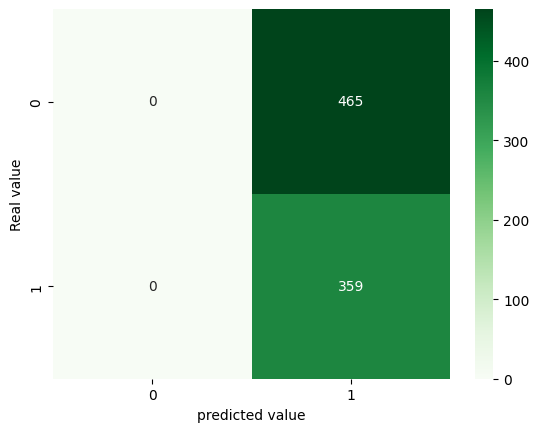

In [350]:
display_results(y_test, models['Siames'][1])

### Эмбеддинг-нейросеть + Предсказательная нейросеть

In [352]:
# Инициализация моделей
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PredictionNetwork(nn.Module):
    def __init__(self, embedding_dim):
        super(PredictionNetwork, self).__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [354]:
# Инициализация моделей
embedding_network = EmbeddingNetwork(input_dim=22, embedding_dim=220)
prediction_network = PredictionNetwork(embedding_dim=220)

# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(embedding_network.parameters()) + list(prediction_network.parameters()), lr=0.001)

# Обучение моделей
for epoch in range(60):
    for batch in train_dataloader:
        x, y = batch

        # Разделение входных данных на пары бойцов
        x1 = x[:, :22]
        x2 = x[:, 22:]

        # Получение эмбеддингов
        embedding1 = embedding_network(x1)
        embedding2 = embedding_network(x2)

        # Предсказание
        outputs = prediction_network(embedding1, embedding2)

        # Расчет потерь
        loss = criterion(outputs, y.view(-1, 1).float())

        # Обратное распространение ошибок
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Эпоха {epoch+1}, потеря: {loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x0 and 22x128)